In [2]:
# Bottom of the page contains what I would have done differently if I had more time.
import pandas as pd
import numpy as np

import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv('loans_full_schema.csv')

data.isna().sum()

# Some issues I am having with the overall dataset is the number of 'NA' values in some of the metrics.  
# For instance, all of the 'joint' metrics had 8500+ out of their 10000 values be NA, making the columns seem useless.

# Another issue I had with the data is that most of the data was categorical, meaning it was harder to find correlations 
# without segmenting/clustering the data into separate groups.

# A final issue I noticed is the sheer number of metrics to deal with, so I want to try to consider only the necessary metrics
# that will be useful for predicting interest rates.  I took out all columns that I thought was either irrelevant or messy.

emp_title                            833
emp_length                           817
state                                  0
homeownership                          0
annual_income                          0
verified_income                        0
debt_to_income                        24
annual_income_joint                 8505
verification_income_joint           8545
debt_to_income_joint                8505
delinq_2y                              0
months_since_last_delinq            5658
earliest_credit_line                   0
inquiries_last_12m                     0
total_credit_lines                     0
open_credit_lines                      0
total_credit_limit                     0
total_credit_utilized                  0
num_collections_last_12m               0
num_historical_failed_to_pay           0
months_since_90d_late               7715
current_accounts_delinq                0
total_collection_amount_ever           0
current_installment_accounts           0
accounts_opened_

In [3]:
cleaner_data = data.drop(['emp_title', 'emp_length', 'verified_income', 'annual_income_joint', 'verification_income_joint', 
                         'debt_to_income_joint', 'months_since_last_delinq', 'months_since_90d_late'], axis=1)
cleaner_data.head()

,state,homeownership,annual_income,debt_to_income,delinq_2y,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,NJ,MORTGAGE,90000.0,18.01,0,2001,6,28,10,70795,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,HI,RENT,40000.0,5.04,0,1996,1,30,14,28800,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,WI,RENT,40000.0,21.15,0,2006,4,31,10,24193,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,PA,RENT,30000.0,10.16,0,2007,0,4,4,25400,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,CA,RENT,35000.0,57.96,0,2008,7,22,16,69839,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


In [4]:
# debt_to_income only has 24 NA values out of 10000, so We will use annual_income and total_debt_limit
# along with a RandomForest to impute these values


## First, We will sample 75% of the data as training, and the rest as will be our testing set.  
# Since this is not time series data, We will do it randomly
# We will use our cleaned-up dataset
train = cleaner_data.sample(frac = .75)
test = cleaner_data.drop(train.index)


#Now, we will train on the latter and make 'predictions' on the null data to impute debt_to_income using a RandomForest 
# regression algorithm with the variables 'annual_income' and 'total_collection_amount_ever'
#  I chose these variables because I wanted one variable that was correlated to debt, and one correlated with income.

train_no_nulls = train.dropna(subset = ['debt_to_income'])
train_nulls = train.drop(train_no_nulls.index)

x = ['annual_income','total_collection_amount_ever']

forestModel = RandomForestRegressor()
forestModel.fit(train_no_nulls[x], train_no_nulls['debt_to_income'])

values = forestModel.predict(X = train_nulls[x])

train_nulls['debt_to_income'] = values.astype(int)

trained = train_no_nulls.append(train_nulls)

trained.describe()

,annual_income,debt_to_income,delinq_2y,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,...,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
count,7.500000e+03,7500.000000,7500.000000,7500.0000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,...,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,7.897852e+04,19.723067,0.217467,2001.3192,1.947733,22.625333,11.415733,1.820459e+05,50975.713333,0.013333,...,0.124667,16237.833333,43.148800,12.425749,474.015291,14339.136923,2484.335244,1891.673045,592.558456,0.103732
std,6.027388e+04,18.128926,0.685544,7.7802,2.367646,11.874062,5.906952,1.845207e+05,52761.523647,0.120378,...,0.336363,10215.259118,10.976426,5.021105,293.081057,9891.046566,3914.458523,3836.051325,506.971162,1.679231
min,0.000000e+00,0.000000,0.000000,1963.0000,0.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,1000.000000,36.000000,5.310000,30.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.500000e+04,11.050000,0.000000,1997.0000,0.000000,14.000000,7.000000,5.118100e+04,19217.750000,0.000000,...,0.000000,8400.000000,36.000000,9.430000,257.840000,6726.705000,930.767500,587.220000,219.985000,0.000000
50%,6.500000e+04,17.490000,0.000000,2003.0000,1.000000,21.000000,10.000000,1.140485e+05,36878.000000,0.000000,...,0.000000,14250.000000,36.000000,11.980000,392.300000,12178.615000,1562.520000,978.650000,443.895000,0.000000
75%,9.500000e+04,25.070000,0.000000,2006.0000,3.000000,29.000000,14.000000,2.643982e+05,65337.250000,0.000000,...,0.000000,22400.000000,60.000000,15.050000,641.005000,19794.092500,2592.072500,1695.997500,816.197500,0.000000
max,1.600001e+06,469.090000,13.000000,2015.0000,26.000000,87.000000,51.000000,3.386034e+06,873713.000000,2.000000,...,3.000000,40000.000000,60.000000,30.940000,1566.590000,40000.000000,41630.443684,40000.000000,4206.180000,45.120000


In [5]:
### This is the second part to imputing debt_to_income.  We will now take our predictions from the training set, and apply it 
# to the testing set, or the other 25% of our data.

test_no_nulls = test.dropna(subset = ['debt_to_income'])
test_nulls = test.drop(test_no_nulls.index)

# Train on the latter and make 'predictions' on the null data to impute monthly_income using a regression algorithm
# with the variables 'number_real_estate_loans_or_lines' and 'number_of_open_credit_lines_and_loans'

forestModel2 = RandomForestRegressor()
forestModel2.fit(test_no_nulls[x], test_no_nulls['debt_to_income'])

values2 = forestModel.predict(X = test_nulls[x])

test_nulls['debt_to_income'] = values2.astype(int)

tested = test_no_nulls.append(test_nulls)

tested.describe()


####  NOTE: The reasoning for all of these steps to impute debt_to_income is that We do not want to create any data leaks/
# bias when we end up visualizing the data and running our algorithms to predict interest_rate

# Now, we have testing and training data all set up to use for our algorithms We will run later whe We 
# try to predict interest_rate!  We will look at these sets of data later...

,annual_income,debt_to_income,delinq_2y,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,...,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
count,2.500000e+03,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,7.995303e+04,20.060208,0.211600,2001.20240,1.989600,22.842400,11.370400,1.882873e+05,51269.112400,0.015200,...,0.121200,16734.190000,43.641600,12.432848,482.775420,14818.255672,2523.933361,1902.774728,620.991756,0.166868
std,7.658135e+04,18.090921,0.678092,7.84217,2.417401,11.920403,5.751733,1.966375e+05,56190.940095,0.143448,...,0.339642,10551.101226,11.182771,4.941611,300.064082,10175.472091,4087.390705,4026.766852,546.775108,2.166544
min,0.000000e+00,0.000000,0.000000,1963.00000,0.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,1000.000000,36.000000,5.310000,32.230000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.500000e+04,11.155000,0.000000,1997.75000,0.000000,14.000000,7.000000,5.250150e+04,19050.750000,0.000000,...,0.000000,8000.000000,36.000000,9.430000,250.590000,6505.515000,919.465000,578.935000,223.532500,0.000000
50%,6.515926e+04,17.955000,0.000000,2003.00000,1.000000,21.000000,10.000000,1.167145e+05,37010.000000,0.000000,...,0.000000,15000.000000,36.000000,11.980000,409.685000,13167.200000,1571.675000,1001.640000,459.100000,0.000000
75%,9.500000e+04,25.105000,0.000000,2006.00000,3.000000,30.000000,14.000000,2.775600e+05,65562.500000,0.000000,...,0.000000,24000.000000,60.000000,15.050000,657.785000,22024.780000,2685.090000,1691.872500,847.650000,0.000000
max,2.300000e+06,315.940000,9.000000,2015.00000,29.000000,87.000000,46.000000,2.761000e+06,942456.000000,3.000000,...,3.000000,40000.000000,60.000000,30.790000,1531.050000,39308.290000,41405.578794,40000.000000,4216.440000,52.980000


In [6]:
renters = cleaner_data.loc[data['homeownership'] == 'RENT']
renters.head()

,state,homeownership,annual_income,debt_to_income,delinq_2y,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
1,HI,RENT,40000.0,5.04,0,1996,1,30,14,28800,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,WI,RENT,40000.0,21.15,0,2006,4,31,10,24193,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,PA,RENT,30000.0,10.16,0,2007,0,4,4,25400,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,CA,RENT,35000.0,57.96,0,2008,7,22,16,69839,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0
9,IL,RENT,30000.0,18.91,0,2001,0,9,6,33114,...,A3,Mar-2018,Current,fractional,Cash,6077.13,391.15,322.87,68.28,0.0


In [33]:
### The first plot is interactive, meaning that I can change the x and y axis to whatever metrics I want.  
# This helps me see any interesting trends between two specific metrics more effectively

import plotly.graph_objects as go
import plotly.express as px

from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact, Layout

def multiplot(xaxis, yaxis):
    fig = px.scatter(renters, x=xaxis, y=yaxis, width=1300, height=650)
    fig.update_layout(title_text="Loan Data",)        
    fig.show("png", block = False)
    fig.write_html("C:\\Users\\StevensUser\\Documents\\side_projects\\myfile.png")

interactive(multiplot, xaxis=list(cleaner_data.columns), yaxis=list(cleaner_data.columns)[2:])


#####  Here, I am running into issues displaying the interactive graph in HTML.  Due to time constraints, to make up for this,
# I am writing the figure to HTML and then displaying it in my GitHub.

interactive(children=(Dropdown(description='xaxis', options=('state', 'homeownership', 'annual_income', 'debt_…

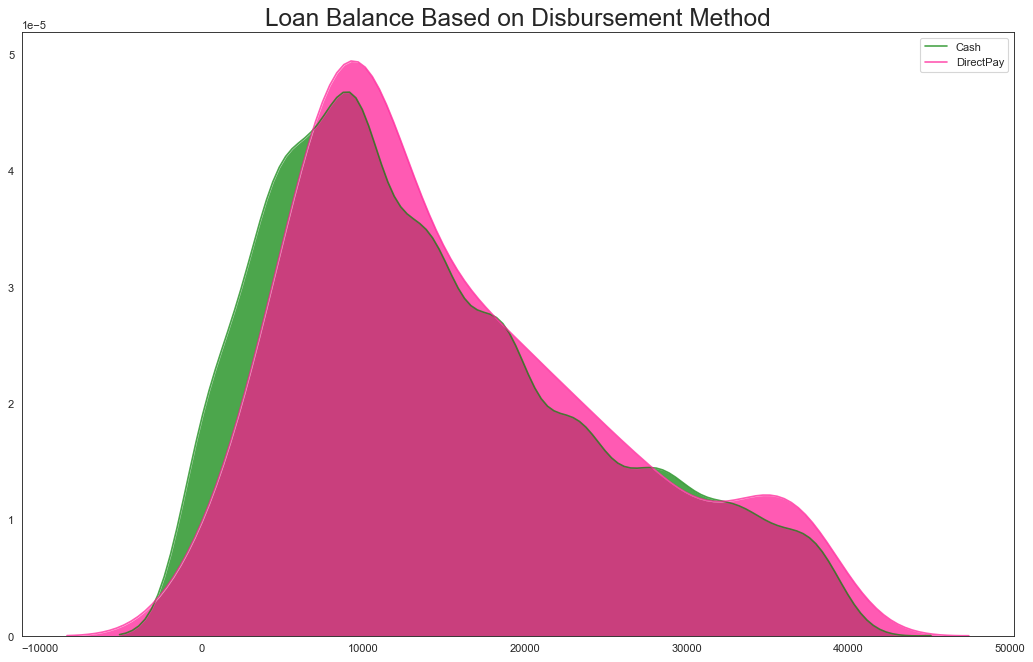

In [59]:
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(cleaner_data.loc[cleaner_data['disbursement_method'] == 'Cash', "balance"], shade=True, color="g", label="Cash", alpha=.7)
sns.kdeplot(cleaner_data.loc[cleaner_data['disbursement_method'] == 'DirectPay', "balance"], shade=True, color="deeppink", label="DirectPay", alpha=.7)
#sns.kdeplot(cleaner_data.loc[cleaner_data['homeownership'] == 'RENT', "annual_income"], shade=True, color="dodgerblue", label="Rent", alpha=.7)

# Decoration
plt.title('Loan Balance Based on Disbursement Method', fontsize=22)
plt.legend()
plt.show()

### This visualization was to see if the method of paying the loan had an impact on whether the borrower was paying the loan back.
#  It does not seem to make a difference on the way the borrower pays the money back.  
#  This gives me reason to get rid of that metric in the regression

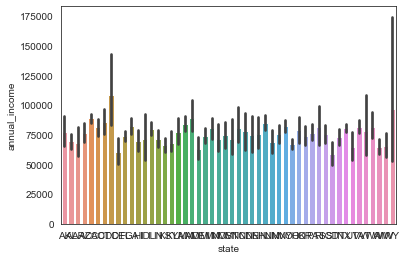

In [40]:
### To make up for the interactive plot not displaying properly, I created a similar plot using metrics I found interesting 
# through the interactive plotly graph.  This time, I opted to graph it using seaborn. 
ordered_state = cleaner_data.sort_values(by=['state'])

import seaborn as sns
sns.barplot(x="state", y="annual_income", data=ordered_state)

### I sorted this graph alphabetically by State so you can get a better idea of which bar equates to which state.
# Interestingly, Wyoming is the state containing loans from lenders with highest annual income.

[Text(0, 0.5, 'debt_to_income'),
 Text(0.5, 0, 'annual income'),
 Text(0.5, 1.0, 'Scatterplot with Histograms of Annual Income vs. Debt to Income')]

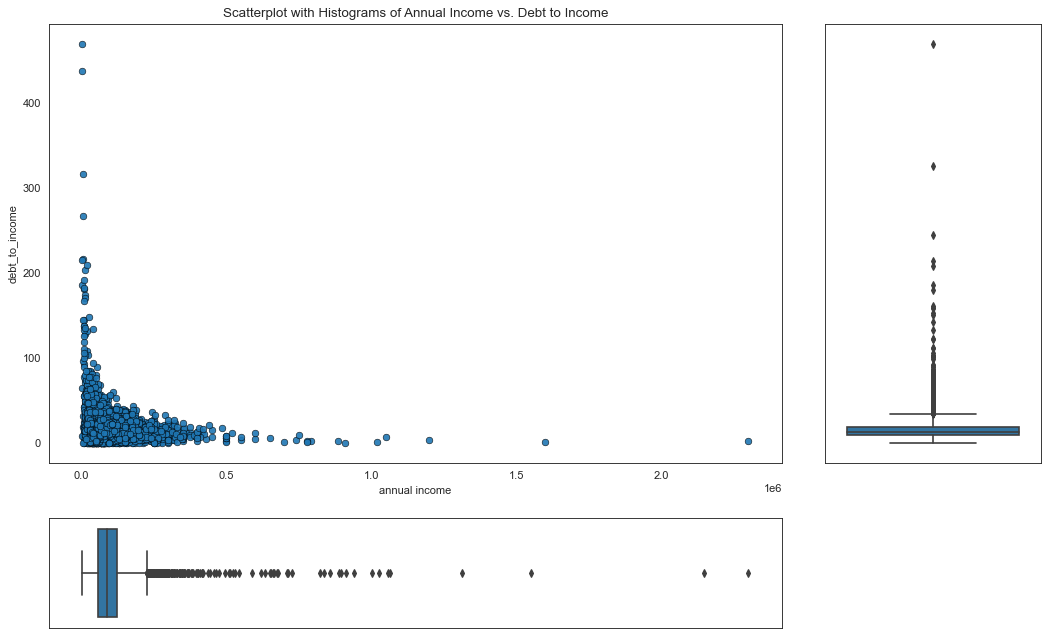

In [46]:
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_main.scatter('annual_income', 'debt_to_income', alpha=.9, data=cleaner_data, cmap="Set1", edgecolors='black', linewidths=.5)

# Add a graph in each part
sns.boxplot(cleaner_data.annual_income, ax=ax_right, orient="v")
sns.boxplot(cleaner_data.debt_to_income, ax=ax_bottom, orient="h")

# Decorations ------------------
# Remove x axis name for the boxplot
ax_bottom.set(xlabel='')
ax_right.set(ylabel='')

# Main Title, Xlabel and YLabel
ax_main.set(title='Scatterplot with Histograms of Annual Income vs. Debt to Income', xlabel='annual income', ylabel='debt_to_income')

### Since annual income is part of the debt_to_income ratio, I thought that plotting the two would show a correlation that could
# lead to using debt as a predictor for interest_rate.  This looks like it is not the case, as both varibales are clusterd around zero
# and both have variables that extend as outliers without any relation to the other variable.


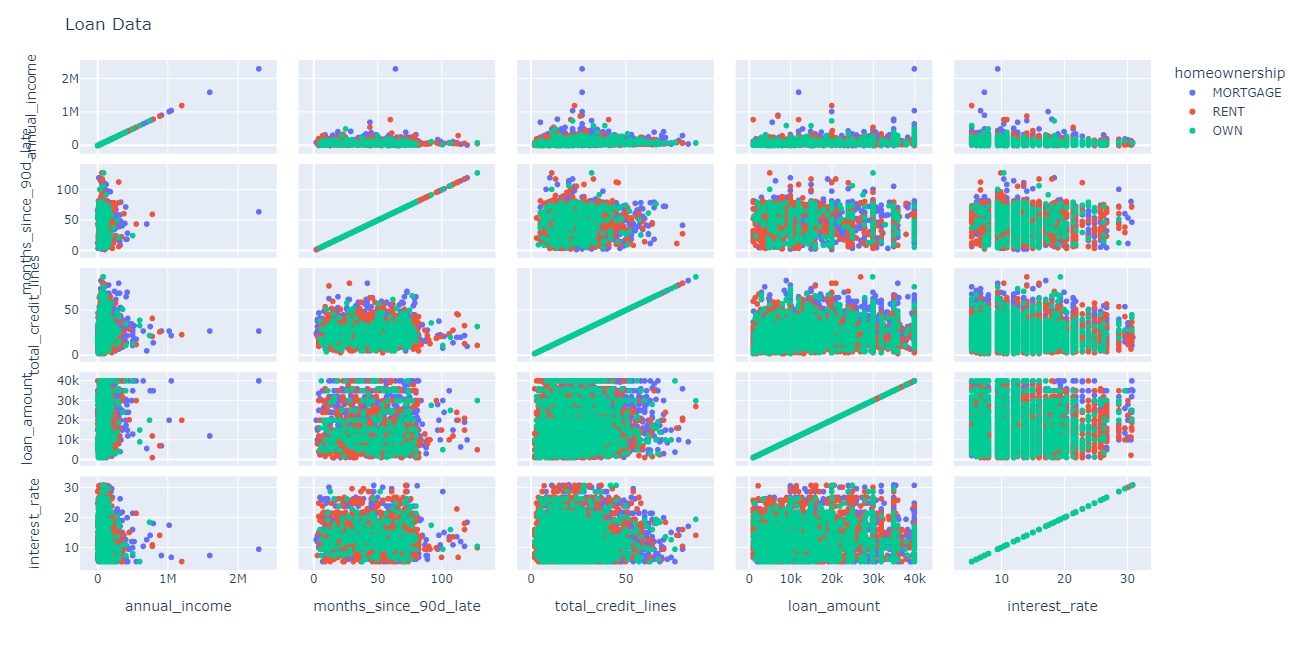

In [9]:
### For my first visualization, I noticed that the outliers contained within the dataset are 
###   typically when the lenders have a Mortgage rather than rent or own their homes (as shown by color of the dots)
###   Let's try to find trends specifically within this outlying data.


fig = px.scatter_matrix(data, dimensions=['annual_income', 'months_since_90d_late', 'total_credit_lines', 'loan_amount', 'interest_rate'], width=1300, height=650,
                        color = 'homeownership', color_continuous_scale=px.colors.diverging.Tealrose)
fig.update_layout(title_text="Loan Data")
fig.show("png")


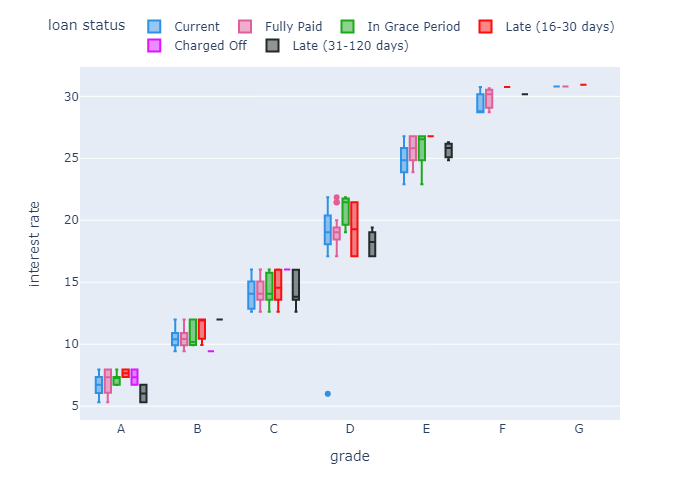

In [56]:
mort = cleaner_data.loc[data['homeownership'] == 'MORTGAGE']

fig = px.box(mort, x="grade", y="interest_rate", color="loan_status",
color_discrete_sequence=px.colors.qualitative.Dark24,
labels={col:col.replace('_', ' ') for col in data.columns},
category_orders={"grade":["A","B","C","D","E","F","G"]})
fig.update_layout(legend=dict(orientation="h", yanchor="bottom",
y=1.02, xanchor="right", x=1))
fig.show("png")

In [158]:
### Algorithm I -> Logistic Regression

# For my first algorithm, I want to use a logistic regression using any relevant metrics I think may have an impact 
# on interest_rate.  Some things I am considering is to create "dummy variables" for my categorical variables so that I can 
# include them in the algorithm.  Due to time constraints, I may pass up on this unfortunately.

# Instead, I will make a subset of the original Trained Set which will include only quantitative metrics.
log_x = trained[['annual_income', 'debt_to_income', 'delinq_2y', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines',
                    'total_credit_limit', 'total_credit_utilized', 'num_collections_last_12m',
                       'num_historical_failed_to_pay', 'current_accounts_delinq',
                       'total_collection_amount_ever', 'current_installment_accounts',
                       'accounts_opened_24m', 'num_satisfactory_accounts', 'num_active_debit_accounts',
                       'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts',
                       'num_cc_carrying_balance', 'num_mort_accounts',
                       'account_never_delinq_percent', 'public_record_bankrupt',
                       'loan_amount', 'balance', 'paid_total', 'paid_principal', 'paid_interest',
                       'paid_late_fees']]
log_x = log_x.astype(int)
y = trained['interest_rate']
y = y.astype(int)
# Logistic regression (sklearn.linear_model.LogisticRegression) using penalty (regularization) L2 

log_reg = LogisticRegression(penalty = "l2", C=20, solver="liblinear")
scores = cross_val_score(log_reg, log_x, y, scoring = 'accuracy', cv=10)
print("Cross Validated Accuracy: %0.3f +/- %0.3f" % (scores.mean(), scores.std()))
# I displayed a Cross Validation to show how well the training set would predict the testing set.

### Downsides to this regression:  
# Given the dataset and time constraints with cleaning the data, I was not able to incorporate a lot of the categorical 
# variables. For that reason, I will use a Decision Tree as my other algorithm which will include segmentation.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 7 members, which is less than n_splits=10.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\U

Cross Validated Accuracy: 0.176 +/- 0.012


C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [185]:
### Algorithm II -> Decision Tree

tree = DecisionTreeClassifier(max_depth = 23)
scores = cross_val_score(tree, log_x, y, scoring = 'accuracy', cv=5)
print("Cross Validated Accuracy: %0.3f +/- %0.3f" % (scores.mean(), scores.std()))

### Using a Decision Tree resulted in a better Cross Validation SCore, meaning that more of the testing set could be predicted by the training set.
# I wanted to use a decision tree so that ever variable within the 'x' input would be considered and analyzed completely.
# On top of that, it is also has a more efficient runtime.

Cross Validated Accuracy: 0.494 +/- 0.021


In [ ]:
### Things I would do if I had more time:
# Combine different metrics to calculate new metrics that could be better associated with interest_rate.
#   This could include calculating poor loan appraisal or using more of the "unverified" loan information. 
# I ran into issues when running my Logistic Regression.  The reason for it was that the values were floats, 
#   meaning that they contained many decimals.  To quickly fix this issue, I switched the type to int's so I could run the Regression.
#   This is not good practice, considering now the values are estimated, leading to worse predictive results.
# Most importantly, I would have utilized more of the categorical varibales by creating a dummy varibale for them.  
#   Doing this would allow me to fully explore the massive set of metrics that were given to me.